# Biodiverisity of Williamson County, Texas

## Problem Description
With this notebook we will be taking a look at some biological obseravtions made by citizen scientists in Williamson County Texas, with the goal of creating a model that can predict the seasonal changes in biodiversity within the county.

### Install the necessary Python Libraries

In [20]:
pip install numpy pandas matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: c:\Users\dillo\.pyenv\pyenv-win\versions\3.10.0\python.exe -m pip install --upgrade pip


### Import the python libraries we will use

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

### Load the dataset and preprocess the datetime values
The dataset we are using comes from inaturalist.com and contains observations in Williamson County, Texas from 2020-2023.
This date range was chosen as it is the most complete and accurate range. During covid of 2020, iNaturalist experienced a major increase in users. The previous years show significantly less observations and were omitted from the dataset

In [5]:
data_path = 'data.csv'
data = pd.read_csv(data_path)

data['observed_on'] = pd.to_datetime(data['observed_on'])
data['year'] = data['observed_on'].dt.year
data['month'] = data['observed_on'].dt.month

C:\Users\dillo\AppData\Local\Temp\ipykernel_64976\3132987853.py:2: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


## Exploratory Data Analysis
Here we will take a look at the dataset and get a view of the monthly observation count, the total observations per genus, and the Shannon Diversity Index over time.

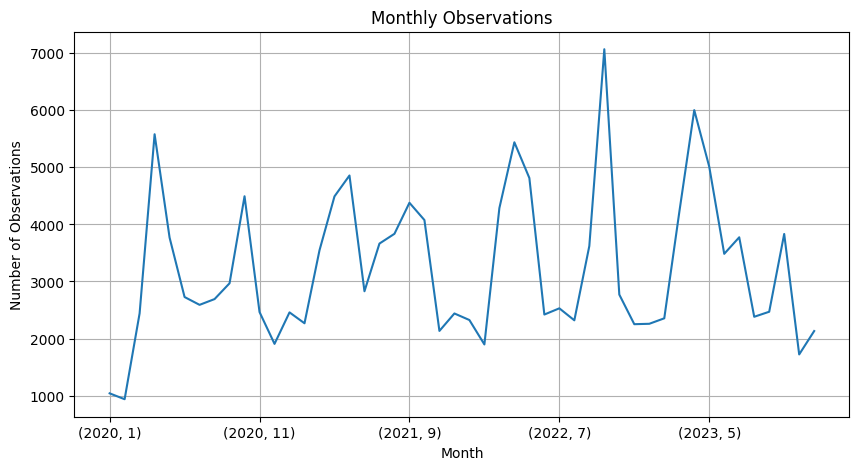

taxon_genus_name
Procyon       3711
Odocoileus    2797
Danaus        2372
Sciurus       2177
Cardinalis    1770
              ... 
Leptochloa       1
Lepraria         1
Leiobunum        1
Pilea            1
Palthis          1
Name: count, Length: 1622, dtype: int64


In [12]:
monthly_counts = data.groupby(['year', 'month']).size()

plt.figure(figsize=(10, 5))
monthly_counts.plot(title='Monthly Observations')
plt.ylabel('Number of Observations')
plt.xlabel('Month')
plt.grid(True)
plt.show()


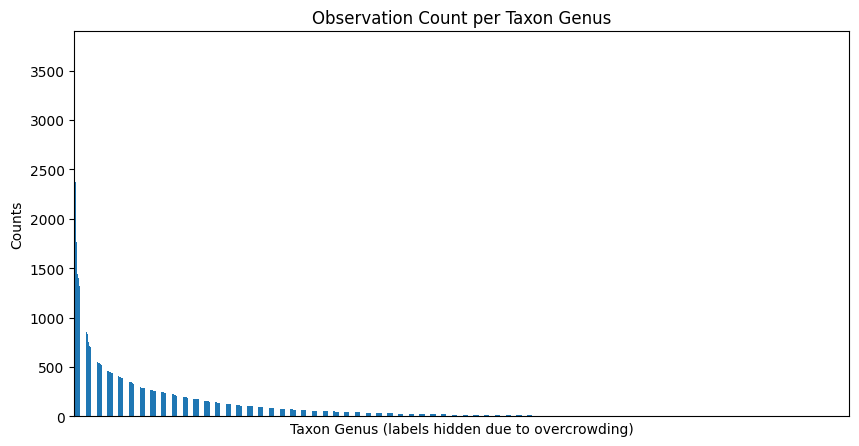

In [18]:
taxon_counts = data['taxon_genus_name'].value_counts()
taxon_counts.plot(kind='bar', figsize=(10, 5), title='Observation Count per Taxon Genus')
plt.ylabel('Counts')
plt.xlabel('Taxon Genus (labels hidden due to overcrowding)')
plt.xticks([])
plt.show()


### Calculate the Shannon Diversity Index for each month
The shannon diversity index takes all of the species in a sampled region and provides a score that conveys the biodiversity of the sample. iNaturalist is an image and location based specimen identification platform and since many species require dissection or microscopy to identify, there is a lack of available species names. Due to this, we will go one step up and use the genus, which will be fine for this proof of concept.

In [7]:
def calculate_shannon_index(df):
    """ Calculate Shannon Diversity Index for a DataFrame """
    species_counts = df['taxon_genus_name'].value_counts()
    total = species_counts.sum()
    proportions = species_counts / total
    shannon_index = -np.sum(proportions * np.log(proportions))
    return shannon_index

monthly_data = data.groupby(['year', 'month']).apply(calculate_shannon_index).reset_index()
monthly_data.columns = ['year', 'month', 'shannon_index']

C:\Users\dillo\AppData\Local\Temp\ipykernel_64976\2020369493.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_data = data.groupby(['year', 'month']).apply(calculate_shannon_index).reset_index()


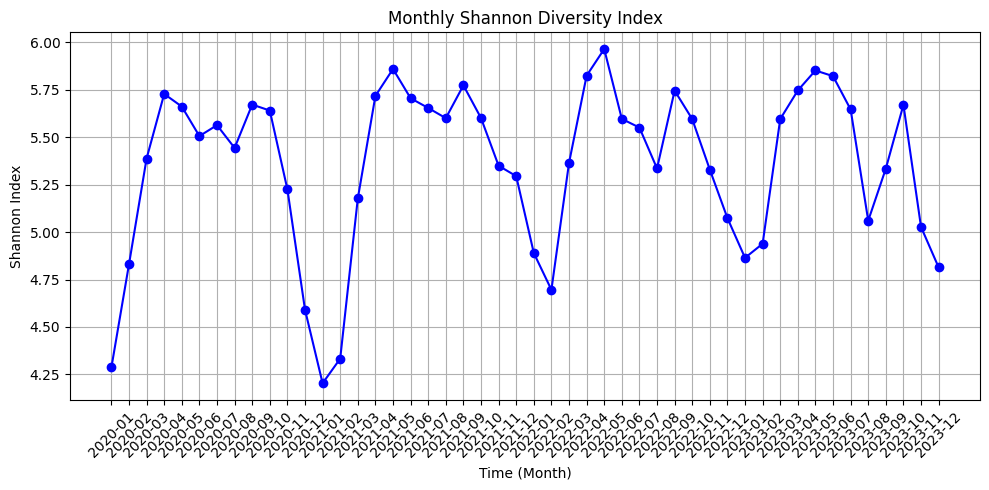

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_data['shannon_index'], marker='o', linestyle='-', color='b')
plt.title('Monthly Shannon Diversity Index')
plt.ylabel('Shannon Index')
plt.xlabel('Time (Month)')
plt.xticks(ticks=range(len(monthly_data)), labels=[f'{y}-{m:02d}' for y, m in zip(monthly_data['year'], monthly_data['month'])], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Analysis

### Split and train a Random Forest model to predict the Shannon Diversity Index
Due to the non-linear relationship of the data and potential for overfitting, we will use a Random Forest Regressor for the model.

In [8]:
X = monthly_data[['year', 'month']]
y = monthly_data['shannon_index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Calculate the RMSE. 
In this case the RMSE is ~0.221 SDI units, which is low enough for us to consider the model to be a good fit.

In [9]:
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 0.2206880065328054


## Result

### Plot the predicted and actual values from the model

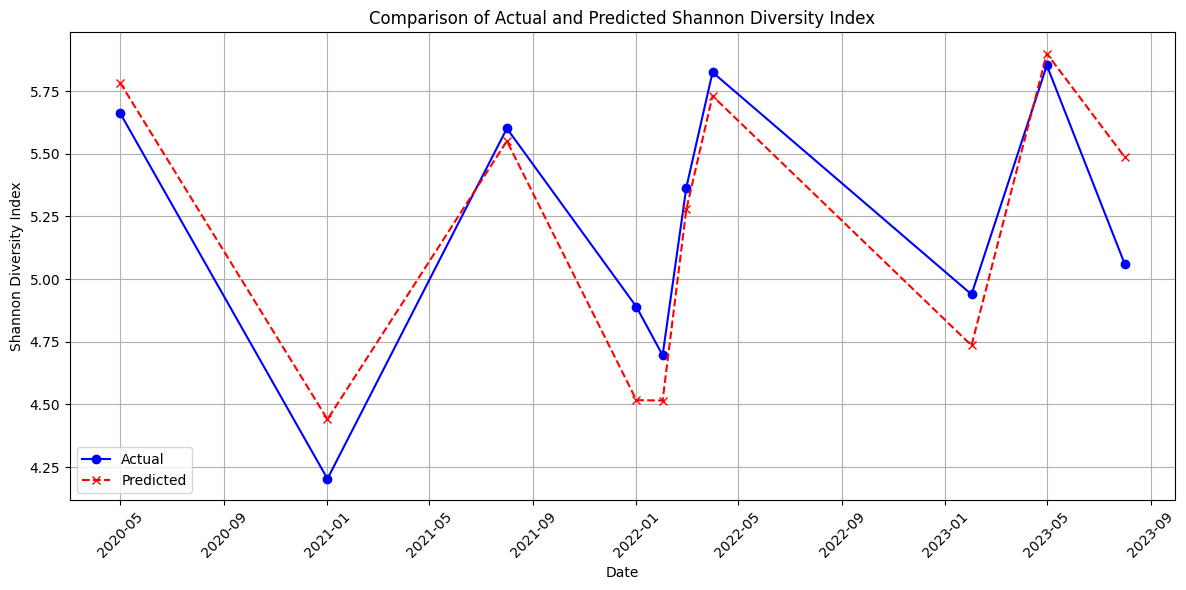

In [10]:
results_df = pd.DataFrame({
    'Year': X_test['year'],
    'Month': X_test['month'],
    'Actual': y_test,
    'Predicted': y_pred
})

results_df['Date'] = pd.to_datetime(results_df[['Year', 'Month']].assign(DAY=1))

results_df.sort_values('Date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual', marker='o', color='blue')
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted', linestyle='--', marker='x', color='red')
plt.title('Comparison of Actual and Predicted Shannon Diversity Index')
plt.xlabel('Date')
plt.ylabel('Shannon Diversity Index')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion
With this model, we can see a variable trend where the SDI decreases in the winter months (showing a decrease in biodiversity) and an increase in the spring (showing an increase in biodiversity). The model also shows a steady increase in the min, max SDI telling us that Williamson County is experiencing a growth in biodiversity. From a personal perspective as a Texas Master Naturalist, I have seen an increase in conservation iniatives and community involvement within Williamson County and this model trend aligns with the growth of those iniatives that aim to preserve and increase the biodiversity of the region through habitat restoration projects. 